Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2. В этом задании можно пользоваться torch.nn, за исключением трансформаций. Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций. Проведите обучение на большом количестве эпох. Опишите, что вы наблюдаете для каждого случая и какая есть разница, если применить трансформации. Предоставьте графики в matplotlib или tensorboard (+1 балл) в ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами

In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
import csv
import numpy as np
from PIL import Image

from transformation import RandomCrop, RandomRotate, RandomZoom, To_tensor, Compose


In [2]:
class Imageset(Dataset):
    def __init__(self, data_container:list[tuple], composer):
        self.data = data_container
        self.composer = composer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][0]
        if self.composer is not None:
            image = self.composer(image)
        image = To_tensor()(image)
        label = np.array(self.data[idx][1])
        return image, label

In [3]:
def read_image_csv(csv_path):
    images_and_labels = []
    with open(csv_path, 'r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)
        for row in csv_reader:
            label = row[0]
            pixels = np.array([int(x) for x in row[1:]], dtype=np.uint8)
            pixels = pixels.reshape(28, 28)
            img = Image.fromarray(pixels, mode='L')  # 'L' mode for grayscale
            images_and_labels.append((img, int(label)))
    return images_and_labels

In [ ]:
import wandb

learning_rate = 1e-3
epochs = 30
prob1 = 0.25; prob2 = 0.05; prob3 = 0.05

wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    notes="first experiment",

    # track hyperparameters and run metadata
    config={
    "learning_rate":learning_rate,
    "epochs": epochs,
    "rotate_prob": prob1,
    "zoom_prob": prob2,
    "crop_prob": prob3,
    }
)

vis here: https://wandb.ai/mode-spbu/my-awesome-project/workspace?nw=nwusermode

In [60]:
t1 = RandomRotate(prob1)
t2 = RandomZoom(prob2)
t3 = RandomCrop(prob3)
composer = Compose([t1,t2,t3])

In [61]:
train_data = Imageset(read_image_csv("../../data/FashionMNIST/fashion-mnist_train.csv"), composer)
test_data = Imageset(read_image_csv("../../data/FashionMNIST/fashion-mnist_test.csv"), None)

In [62]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [63]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


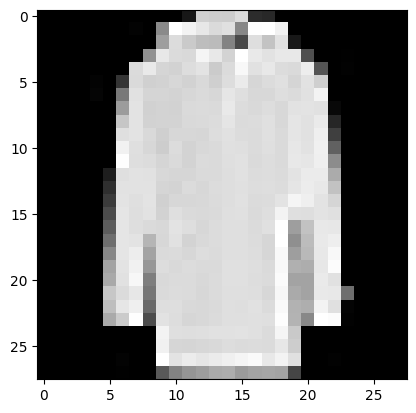

Label: Coat


In [64]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {labels_map[int(label)]}")

In [65]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(1,8,3),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.head = nn.Linear(10816, 10)

    def forward(self, x):
        x = self.base(x)
        x = x.view(x.size(0), -1)
        logits = self.head(x)
        return logits

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (base): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (head): Linear(in_features=10816, out_features=10, bias=True)
)


In [66]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs, targets
        preds = model(inputs)
        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss
        if batch_idx % 100 == 0:
            loss, current = loss.item(), (batch_idx + 1) * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    return train_loss

In [67]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, num_correct = 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            model.eval()
            preds = model(inputs)
            loss = loss_fn(preds, targets)
            test_loss += loss
            num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()
    test_loss /= num_batches
    num_correct /= size
    print(f"Test Error: \n Accuracy: {(100*num_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, num_correct*100

In [68]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [69]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    l1 = train(train_dataloader, model, loss_fn, optimizer)
    l2 = test(test_dataloader, model, loss_fn)
    wandb.log({"accuracy_test": l2[1], "loss_train": l1, "loss_test":l2[0]})

Epoch 1
-------------------------------


loss: 2.376179  [   64/60000]
loss: 1.469633  [ 6464/60000]
loss: 1.334056  [12864/60000]
loss: 1.271373  [19264/60000]
loss: 1.160839  [25664/60000]
loss: 0.917239  [32064/60000]
loss: 1.101271  [38464/60000]
loss: 0.933753  [44864/60000]
loss: 1.338295  [51264/60000]
loss: 1.125067  [57664/60000]
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.597868 

Epoch 2
-------------------------------
loss: 1.164831  [   64/60000]
loss: 0.860125  [ 6464/60000]
loss: 0.987114  [12864/60000]
loss: 1.020216  [19264/60000]
loss: 0.846467  [25664/60000]
loss: 0.976571  [32064/60000]
loss: 1.094007  [38464/60000]
loss: 0.750029  [44864/60000]
loss: 1.047176  [51264/60000]
loss: 0.974062  [57664/60000]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.527760 

Epoch 3
-------------------------------
loss: 0.824545  [   64/60000]
loss: 0.799580  [ 6464/60000]
loss: 0.820284  [12864/60000]
loss: 0.870684  [19264/60000]
loss: 0.842204  [25664/60000]
loss: 0.930843  [32064/60000]
loss: 0.917665  [38464/60000]
loss: 